In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import nxviz as nv
import numpy as np
from operator import itemgetter

### Bipartite Graphs

- A graph that is partitioned into two sets
- Nodes are only connected to nodes in the other partition
- The previous examples are unipartite nodes

##### Example of Bipartite Graphs

<img src="../../images/bipartite_example.png" width="300" height="300">

Let's create a bipartite graph

In [2]:
# Initialize graph 
G = nx.Graph()

In [3]:
# Create some nodes
nodes_1 = np.arange(3)
nodes_2 = ["a", "b", "c", "d"]
# Add nodes to the initialized graph specifiying the partition
G.add_nodes_from(nodes_for_adding=nodes_1, bipartite="Products")
G.add_nodes_from(nodes_for_adding=nodes_2, bipartite="Customers")

Let us see how the nodes look like now:

In [4]:
G.nodes(data=True)

NodeDataView({0: {'bipartite': 'Products'}, 1: {'bipartite': 'Products'}, 2: {'bipartite': 'Products'}, 'a': {'bipartite': 'Customers'}, 'b': {'bipartite': 'Customers'}, 'c': {'bipartite': 'Customers'}, 'd': {'bipartite': 'Customers'}})

How to get the nodes for the in the partition customer?

In [5]:
nodes_customers = [n for n, d in G.nodes(data=True) if d['bipartite']=='Customers']
print(nodes_customers)

['a', 'b', 'c', 'd']


Let us look at some network data from github:

In [6]:
df_github = pd.read_csv("../../data/network/github/github.edges", skiprows=2)

In [7]:
df_github = df_github.astype(str)

In [8]:
users = "u" + df_github["1"]
projects = "p" + df_github["1.1"]

In [9]:
subset_no = 20

In [10]:
edges = list(zip(users, projects))

In [11]:
filtered_edges = edges[1000:1000+subset_no]

In [12]:
users_fil = list(map(itemgetter(0), filtered_edges))
projs_fil = list(map(itemgetter(1), filtered_edges))

In [13]:
# Initialize the graph
G = nx.Graph()

In [14]:
# Add user nodes, use bipartite attribute
G.add_nodes_from(users_fil, bipartite='USERS')
#  Add project nodes
G.add_nodes_from(projs_fil, bipartite='PROJECTS')
# Add edges
G.add_edges_from(filtered_edges)

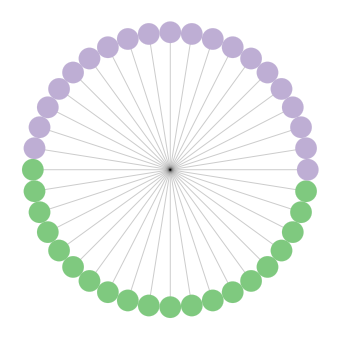

In [15]:
c = nv.CircosPlot(G, node_color='bipartite', node_grouping='bipartite')
c.draw()

In [16]:
node_attribute = 10*np.abs(np.random.random(2*subset_no,))

In [17]:
all_nodes = list(G.nodes())

In [18]:
attrs = {}

In [19]:
#  Create dictionary of attribute
for i in range(2*subset_no):
    attrs[all_nodes[i]]={'importance': node_attribute[i]} 

In [20]:
nx.set_node_attributes(G, attrs)

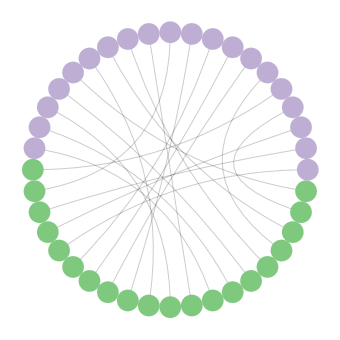

In [21]:
c = nv.CircosPlot(G, node_color = 'bipartite',
                  node_grouping = 'bipartite',
                  node_order = 'importance')
c.draw()

### Bipartite graphs and recommendation systems


<img src="../../images/bipartite_example.png" width="300" height="300">

Built a graph with all the edges in the github network

In [22]:
G_all = nx.Graph(edges)

Make a bipartite graph by appropriately attributing all the nodes

In [23]:
users = list(map(itemgetter(0), edges))
projects = list(map(itemgetter(1), edges))

In [24]:
# Add user nodes, use bipartite attribute
G_all.add_nodes_from(users, bipartite='USERS')
#  Add project nodes
G_all.add_nodes_from(projects, bipartite='PROJECTS')

In [25]:
print(f"The total no. of nodes are: {len(G_all.nodes())}")

The total no. of nodes are: 177385


#### Building a basic recommender system

Step1: Let us write a function which will allow us to find all the common neighbors for two nodes belonging to the same partition. Remember that in a bipartite graph neighbors of nodes have to be in a different partition.

In [26]:
def shared_partition_nodes(G, node1, node2):
    # Check that the nodes belong to the same partition
    assert G.node[node1]['bipartite'] == G.node[node2]['bipartite']

    # Get neighbors of node 1: nbrs1
    nbrs1 = G.neighbors(node1)
    # Get neighbors of node 2: nbrs2
    nbrs2 = G.neighbors(node2)

    # Compute the overlap using set intersections
    overlap = set(nbrs1).intersection(nbrs2)
    return overlap

# Print the number of shared repositories between users 'u7909' and 'u2148'
print(shared_partition_nodes(G_all, 'u7909', 'u2148'))

{'p1527', 'p4735', 'p607', 'p1073', 'p101', 'p665', 'p2000', 'p299', 'p15', 'p504', 'p645', 'p911', 'p14961', 'p6', 'p558', 'p2332', 'p930'}


##### Computing the similarity between two nodes

In order to compute the similartiy between two nodes or in the case of this example, first compute the number of shared projects. Then we define the similarity as:
\begin{equation}
\text{Similarity Metric} = \frac{\text{Total number of shared projects}}{\text{Total no of nodes in the projects partition}}
\end{equation}

Let us first write a function to obtain the number of nodes in a given partition:

In [27]:
def get_nodes_from_partition(G, partition):
    return [n for n, d in G.nodes(data=True) if d['bipartite'] == partition]

Time to define the function for computing similarity

In [28]:
def user_similarity(G, user1, user2, proj_nodes):
    # Check that the nodes belong to the 'users' partition
    assert G.node[user1]['bipartite'] == 'USERS'
    assert G.node[user2]['bipartite'] == 'USERS'

    # Get the set of nodes shared between the two users
    shared_nodes = shared_partition_nodes(G, user1, user2)

    # Return the fraction of nodes in the projects partition
    return len(shared_nodes) / len(proj_nodes)

In [29]:
# Compute the similarity score between users 'u4560' and 'u1880'
project_nodes = get_nodes_from_partition(G_all, 'PROJECTS')
similarity_score = user_similarity(G_all, 'u4560', 'u1880', project_nodes)

In [30]:
print(f"The total number of project nodes were {len(project_nodes)}")
print(f"Similarity score is {similarity_score}")

The total number of project nodes were 120866
Similarity score is 9.100987870865256e-05


The score is pretty small, however this is all relative, and it would be interesting to see other nodes as well.

This is where things will get interesting, given a user, using the similarity metric, we should be able to find out which users are most similar to it. 

In [31]:
from collections import defaultdict

def most_similar_users(G, user, user_nodes, proj_nodes):
    # Data checks
    assert G.node[user]['bipartite'] == 'USERS'

    # Get other nodes from user partition
    user_nodes = set(user_nodes)
    user_nodes.remove(user)

    # Create the dictionary: similarities
    similarities = defaultdict(list)
    for n in user_nodes:
        similarity = user_similarity(G, user, n, proj_nodes)
        similarities[similarity].append(n)

    # Compute maximum similarity score: max_similarity
    max_similarity = max(similarities.keys())
    # Return list of users that share maximal similarity
    return similarities[max_similarity]

In [32]:
user_nodes = get_nodes_from_partition(G_all, 'USERS')
project_nodes = get_nodes_from_partition(G_all, 'PROJECTS')

print(most_similar_users(G_all, 'u1', user_nodes, project_nodes))

['u922', 'u5451']


Given that we now know the most similar users to a given user, we are now in the position to recommend projects to the similar users. Consider the user 'u7909', let us find the most similar user:

In [33]:
print(most_similar_users(G_all, 'u7909', user_nodes, project_nodes))

['u83']


Given that the 'u83' is the most similar to 'u7909' we can now recommend some projects to 'u83'. The projects which are in 'u7909' but not in 'u83' are the ones which can be recommended:

In [34]:
def recommend_repositories(G, from_user, to_user):
    # Get the set of repositories that from_user has contributed to
    from_repos = set(G.neighbors(from_user))
    # Get the set of repositories that to_user has contributed to
    to_repos = set(G.neighbors(to_user))

    # Identify repositories that the from_user is connected to that the to_user is not connected to
    return from_repos.difference(to_repos)

In [35]:
# Print the repositories to be recommended
print(recommend_repositories(G_all, 'u7909', 'u83'))

{'p4735', 'p3171', 'p12466', 'p162', 'p2329', 'p3108', 'p22339', 'p6', 'p4988', 'p721', 'p49699', 'p84', 'p16271', 'p1831', 'p2324', 'p5660', 'p14571', 'p1896', 'p82144', 'p15697', 'p824', 'p1222', 'p2895', 'p22332', 'p1073', 'p101', 'p504', 'p4078', 'p37057', 'p909', 'p1950', 'p29736', 'p2000', 'p1092', 'p2392', 'p11674', 'p200', 'p585', 'p63442', 'p744', 'p8146', 'p911', 'p7408', 'p2906', 'p30948', 'p930', 'p16548', 'p1840'}
